In [7]:
import os
import json
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
data_path = Path('../abstraction-and-reasoning-challenge/data')
train_path = data_path / 'training'
valid_path = data_path / 'evaluation'
test_path = data_path / 'test'

train_tasks = { task.stem: json.load(task.open()) for task in train_path.iterdir() } 
valid_tasks = { task.stem: json.load(task.open()) for task in valid_path.iterdir() } 


In [9]:
cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
    
def plot_pictures(pictures, labels):
    fig, axs = plt.subplots(1, len(pictures), figsize=(2*len(pictures),32))
    for i, (pict, label) in enumerate(zip(pictures, labels)):
        axs[i].imshow(np.array(pict), cmap=cmap, norm=norm)
        axs[i].set_title(label)
    plt.show()
    
def plot_sample(sample, predict=None):
    if predict is None:
        plot_pictures([sample['input'], sample['output']], ['Input', 'Output'])
    else:
        plot_pictures([sample['input'], sample['output'], predict], ['Input', 'Output', 'Predict'])
        
def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img

def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])


def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

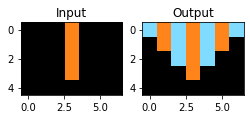

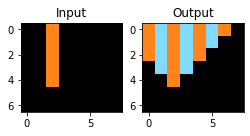

In [10]:
task = train_tasks["db3e9e38"]["train"]
for sample in task:
    plot_sample(sample)

In [11]:
class CAModel(nn.Module):
    def __init__(self, num_states):
        super(CAModel, self).__init__()
        self.transition = nn.Sequential(
            nn.Conv2d(num_states, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, num_states, kernel_size=1)
        )
        
    def forward(self, x, steps=1):
        for _ in range(steps):
            x = self.transition(torch.softmax(x, dim=1))
        return x

In [12]:
def solve_task(task, max_steps=10):
    model = CAModel(10).to(device)
    num_epochs = 100
    criterion = nn.CrossEntropyLoss()
    losses = np.zeros((max_steps - 1) * num_epochs)

    for num_steps in range(1, max_steps):
        optimizer = torch.optim.Adam(model.parameters(), lr=(0.1 / (num_steps * 2)))
        
        for e in range(num_epochs):
            optimizer.zero_grad()
            loss = 0.0

            for sample in task:
                # predict output from input
                x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
                y = torch.tensor(sample["output"]).long().unsqueeze(0).to(device)
                y_pred = model(x, num_steps)
                loss += criterion(y_pred, y)
                
                # predit output from output
                # enforces stability after solution is reached
                y_in = torch.from_numpy(inp2img(sample["output"])).unsqueeze(0).float().to(device)
                y_pred = model(y_in, 1) 
                loss += criterion(y_pred, y)

            loss.backward()
            optimizer.step()
            losses[(num_steps - 1) * num_epochs + e] = loss.item()
    return model, num_steps, losses
                
@torch.no_grad()
def predict(model, task):
    predictions = []
    for sample in task:
        x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
        pred = model(x, 100).argmax(1).squeeze().cpu().numpy()
        predictions.append(pred)
    return predictions
    
task = train_tasks["db3e9e38"]["train"]
model, num_steps, losses = solve_task(task)

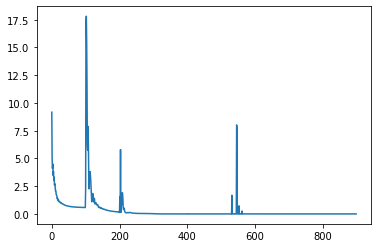

In [14]:
plt.plot(losses)

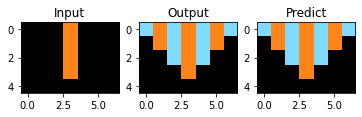

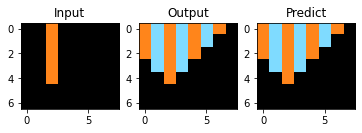

In [15]:
predictions = predict(model, task)
for i in range(len(task)):
    plot_sample(task[i], predictions[i])

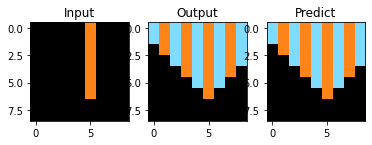

In [16]:
test = train_tasks["db3e9e38"]["test"]
predictions = predict(model, test)
for i in range(len(test)):
    plot_sample(test[i], predictions[i])

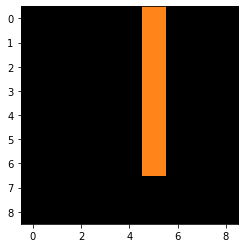

In [17]:
def animate_solution(model, sample):
    x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)

    @torch.no_grad()
    def animate(i):
        pred = model(x, i)
        im.set_data(pred.argmax(1).squeeze().cpu().numpy())

    fig, ax = plt.subplots()
    im = ax.imshow(x.argmax(1).squeeze().cpu().numpy(), cmap=cmap, norm=norm)
    return animation.FuncAnimation(fig, animate, frames=100, interval=120)
    
anim = animate_solution(model, train_tasks["db3e9e38"]["test"][0])
HTML(anim.to_jshtml())

In [18]:
def evaluate(tasks):
    result = []
    predictions = []
    for idx, task in tqdm(tasks.items()):
        if input_output_shape_is_same(task):
            model, _, _ = solve_task(task["train"])
            pred = predict(model, task["test"])
            score = calk_score(task["test"], pred)
        else:
            pred = [el["input"] for el in task["test"]]
            score = [0] * len(task["test"])

        predictions.append(pred)
        result.append(score)
    return result, predictions

In [ ]:
train_result, train_predictions = evaluate(train_tasks)
train_solved = [any(score) for score in train_result]

total = sum([len(score) for score in train_result])
print(f"solved : {sum(train_solved)} from {total} ({sum(train_solved)/total})")

 96%|█████████▌| 383/400 [11:46:26<3:35:36, 760.97s/it]  

In [ ]:
for task, prediction, solved in tqdm(zip(train_tasks.values(), train_predictions, train_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])